# Comparison of Discretization Schemes for a Simple Pendulum

In this notebook, we will compare different discretization schemes for simulating a simple pendulum. We will use the following methods:
- Euler Forward
- Euler Forward with 2 steps
- Runge-Kutta 2nd order (RK2)
- Runge-Kutta 4th order (RK4)

First, we will define the pendulum model and the necessary functions for integration and simulation.

## Define the Pendulum Model

The dynamics of the simple pendulum can be described using the following differential equations:

$$
\begin{align*}
\dot{\theta} &= \theta_{dot} \\
\dot{\theta_{dot}} &= \frac{m \cdot g \cdot l \cdot \sin(\theta) + m \cdot l \cdot \cos(\theta) \cdot u}{I + m \cdot l^2}
\end{align*}
$$

Where:
- $\theta$ is the angle of the pendulum.
- $\theta_{dot}$ is the angular velocity.
- $u$ is the control input (torque).
- $m$ is the mass.
- $l$ is the length of the pendulum.
- $I$ is the moment of inertia.
- $g$ is the acceleration due to gravity.

Let's define the pendulum model in CasADi.

In [1]:
# Import necessary libraries
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

from NonlinearMPC import NonlinearSystem, Integrator, simulate_system

# Define the ODE right-hand side function for the simple pendulum model
th = ca.MX.sym("th")
thDot = ca.MX.sym("thDot")
u = ca.MX.sym("u")  # Control input or parameter

m = 0.2
l = 0.3
I = 0.006
g = 9.81

a = m * g * l / (I + m * l**2)
b = m * l / (I + m * l**2)

rhs = ca.vertcat(
    thDot,            # dth/dt
    a * ca.sin(th) + b * ca.cos(th) * u  # dth_dot/dt
)

# Create the NonlinearSystem object
states = ca.vertcat(th, thDot)
inputs = u
pendulum_system = NonlinearSystem(updfcn=rhs, states=states, inputs=inputs)


## Simulation parameters

Next, we will define the simulation parameters including the time step, total simulation time, and the initial state of the pendulum.

In [2]:
# Simulation parameters
dt = 0.1  # Integration interval
Tsim = 3.0  # Total simulation time
N_steps = int(Tsim / dt)  # Number of simulation steps
initial_state = np.array([3 * np.pi / 4, 0])  # Initial state [theta, theta_dot]

## Define integration schemes

We will use the provided RK and forward_euler functions from the nonlinear_mpc package to define the different integration schemes.

In [3]:
# Define the integration schemes
rk4_integrator = Integrator(pendulum_system, 'RK4', dt, order=4)
rk2_integrator = Integrator(pendulum_system, 'RK2', dt, order=2)
euler_integrator = Integrator(pendulum_system, 'Euler', dt, steps=1)
euler_2steps_integrator = Integrator(pendulum_system, 'Euler', dt, steps=2)

## Simulate the System Using Different Integrators

We will simulate the system using the different integrators and compare the results.

In [4]:
# Simulate the system using different integrators
x_euler = simulate_system(euler_integrator, initial_state, N_steps)
x_euler_2steps = simulate_system(euler_2steps_integrator, initial_state, N_steps)
x_rk2 = simulate_system(rk2_integrator, initial_state, N_steps)
x_rk4 = simulate_system(rk4_integrator, initial_state, N_steps)

## Plot the Results

Finally, we will plot the results of the simulations. The plots will include small squares at each sampling instant to indicate the time steps.

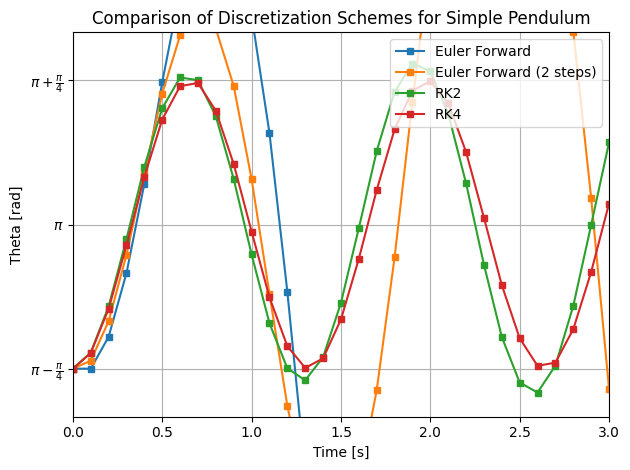

In [5]:
# Time grid for plotting
t_sim = np.linspace(0, Tsim, N_steps + 1)

# Plot the results
plt.figure()

plt.plot(t_sim, x_euler[0, :], label='Euler Forward', marker='s', markersize=4)
plt.plot(t_sim, x_euler_2steps[0, :], label='Euler Forward (2 steps)', marker='s', markersize=4)
plt.plot(t_sim, x_rk2[0, :], label='RK2', marker='s', markersize=4)
plt.plot(t_sim, x_rk4[0, :], label='RK4', marker='s', markersize=4)

plt.xlabel('Time [s]')
plt.ylabel('Theta [rad]')
plt.title('Comparison of Discretization Schemes for Simple Pendulum')
plt.legend(loc='upper right')
plt.grid(True, which='both')

# Custom Y grid lines
plt.yticks([np.pi - np.pi/4, np.pi, np.pi + np.pi/4], 
           [r'$\pi - \frac{\pi}{4}$', r'$\pi$', r'$\pi + \frac{\pi}{4}$'])

# Adjust Y limits
plt.ylim([2/3 * np.pi, 4/3 * np.pi])
plt.xlim([0, Tsim])

# Save the plot as PDF
plt.tight_layout()
plt.savefig('discretization_comparison.pdf', format='pdf')

plt.show()